# Lumoshive Data Science Final Project

### Basic Configurations

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import math
import seaborn as sns
import re

## SKlearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.calibration import LabelEncoder

In [175]:
df_tr = pd.read_csv("transactions_mix.csv")
df_sb = pd.read_csv("subscriptions_mix.csv")
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)

C:\Users\samsu\AppData\Local\Temp\ipykernel_13940\312146456.py:1: DtypeWarning: Columns (4,6,10,13,14,15,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tr = pd.read_csv("transactions_mix.csv")
C:\Users\samsu\AppData\Local\Temp\ipykernel_13940\312146456.py:2: DtypeWarning: Columns (4,6,10,13,16,18,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb = pd.read_csv("subscriptions_mix.csv")


In [4]:
df_tr

,id,created_at,country,operator,service,source,msisdn,event,event_date,cycle,revenue,currency,charge_date,publisher,handset,browser,trxid,telco_api_url,telco_api_response,sms_content,status_sms
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,daily,0:00,NaN,2023-08-08 00:35:39.000,NaN,NaN,NaN,c3c31cc6-f59c-4d3d-b50d-82b1d1ad5bb0,NaN,NaN,NaN,1
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,daily,150:00:00,NaN,2023-08-08 00:00:36.000,NaN,NaN,NaN,c0c13113-f39c-4ae6-aa24-d95b5d16130b,NaN,NaN,NaN,1
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,daily,150:00:00,NaN,2023-08-08 00:03:18.000,NaN,NaN,NaN,9f31aeb4-50c2-4b2b-90d3-76a8894e0dd5,NaN,NaN,NaN,1
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,daily,0:00,NaN,2023-08-08 01:09:12.000,NaN,NaN,NaN,58dedf99-cfe0-4ab2-822b-4c518c85ca31,NaN,NaN,NaN,1
4,5,2023-09-13 16:50:38.944,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-YpWV5oqkXjJjzuM2fXU6K5MharguG0qWqPC...,renewal,2023-08-08 00:03:20.000,daily,150:00:00,NaN,2023-08-08 00:03:20.000,NaN,NaN,NaN,80e6922b-b479-40dd-8c5b-0a991fd8828b,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505425,46747,2023-09-13 15:45:38.791,LA,etl,slypee,cp1,2028847296,renewal,2023-08-25 14:38:28.000,daily,0,LAK,2023-08-25 14:38:28.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,"Error MSG: ABM fee not enough, Freeze fee failed!",NaN,NaN
505426,46735,2023-09-13 15:45:38.790,LA,etl,slypee,cp1,2029307038,renewal,2023-08-25 14:32:53.000,daily,0,LAK,2023-08-25 14:32:53.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,"Error MSG: ABM fee not enough, Freeze fee failed!",NaN,NaN
505427,46751,2023-09-13 15:45:38.795,LA,etl,slypee,cp1,2022909035,first_charge,2023-08-25 12:41:05.000,daily,2000,LAK,2023-08-25 12:41:05.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,NaN,NaN,NaN
505428,46740,2023-09-13 15:45:38.791,LA,etl,slypee,cp1,2029315559,first_charge,2023-08-25 12:27:43.000,daily,0,LAK,2023-08-25 12:27:43.000,lumos,NaN,No Detected,NaN,http://182.16.255.85:8093/ETLPaymentTopup/serv...,"Error MSG: ABM fee not enough, Freeze fee failed!",NaN,NaN


In [41]:
df_sb

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,freemium_end_date,unsubs_from,unsubs_date,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,marvel,0,2022-10-20 19:28:02.000,2023-09-14 00:00:00.000,2022-10-20 00:00:00.000,mo_ussd,2023-08-03 14:12:59.000,6,BATH,Active,lumos,20230913070749401088.0,no,not found,Go-http-client,15,0
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,marvel,0,2020-08-23 16:11:02.000,2023-09-14 00:00:00.000,2020-08-23 00:00:00.000,mo_ussd,2023-08-03 14:12:59.000,6,BATH,Active,lumos,20230913070724300800.0,no,not found,Go-http-client,15,0
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,1,marvel,6,2023-08-25 14:02:05.000,2023-08-26 00:00:00.000,2023-08-25 00:00:00.000,mo_ussd,2023-08-03 14:12:59.000,6,BATH,Active,lumos,20230825140205699072.0,no,not found,Go-http-client,1,1
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,star,0,2023-09-09 13:03:24.000,2023-09-14 00:00:00.000,2023-09-09 00:00:00.000,mo_ussd,2023-08-03 14:12:59.000,6,BATH,Active,star,20230913071052099584.0,star-APP1694223212644066,not found,Go-http-client,5,0
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,marvel,0,2022-09-26 19:36:03.000,2023-09-14 00:00:00.000,2022-09-26 00:00:00.000,mo_ussd,2023-08-03 14:12:59.000,6,BATH,Active,lumos,20230913070115598336.0,no,not found,Go-http-client,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,2022-10-15 00:00:00.000,mo_ussd,0001-01-01 00:00:00.000,300,Rial,Active,lumos,1.69E+22,no,/,Apache-HttpClient,1,0
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,2022-10-15 00:00:00.000,mo_ussd,0001-01-01 00:00:00.000,300,Rial,Active,lumos,1.69E+22,no,/,Apache-HttpClient,1,0
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,2022-10-15 00:00:00.000,mo_ussd,0001-01-01 00:00:00.000,300,Rial,Active,lumos,1.69E+22,no,/,Apache-HttpClient,1,0
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,2022-10-15 00:00:00.000,mo_ussd,0001-01-01 00:00:00.000,300,Rial,Active,lumos,1.69E+22,no,/,Apache-HttpClient,1,0


### View Data

#### General

##### Operator

In [164]:
print("Transaction Table")
print(df_tr["operator"].unique())
print("Subscriptions Table")
print(df_sb["operator"].unique())
## TODO: Lowercase

Transaction Table
['sen-orange-mtarget' 'ais' 'omantel' 'ltc' 'etl']
Subscriptions Table
['ais' 'sen-orange-mtarget' 'etl' 'tplus' 'ltc' 'omantel']


##### Country Type

In [197]:
print("Transaction Table")
print(df_tr["country"].unique())
print("Subscriptions Table")
print(df_sb["country"].unique())

Transaction Table
['SN' 'TH' 'OM' 'LA']
Subscriptions Table
['TH' 'SN' 'LA' 'OM']


##### Service

In [207]:
print("Transaction Table")
print(df_tr["service"].unique())
print("Subscriptions Table")
print(df_sb["service"].unique())

## TODO: Change the datatype to varchar everything

Transaction Table
['gemezz' '459505104' '459505105' '459509903' '459505106' '459509902'
 '459509901' 'goaly' 'halogame' 'slypee']
Subscriptions Table
['459505104' '459505106' '459505105' '459509902' '459509903' '459509901'
 'gemezz' 'slypee' 'halogame' 'goaly']


##### Source

In [204]:
print("Transaction Table")
print(df_tr["source"].unique())
print("Subscriptions Table")
print(df_sb["source"].unique())
## TODO: Lower case, USSD_W, mo_USSD and USSD_D can be changed to USSD

Transaction Table
['none' 'sms' 'wap' 'ivr' 'cp1' 'lp1' 'default' 'lp2' 'lp6' 'mo_ussd'
 'portal' 'lp7' 'mo_sms' 'ussd' 'lp3' 'lp4']
Subscriptions Table
['sms' 'ivr' 'wap' 'web' 'none' 'ussd' 'cp1' 'lp3' 'lp4' 'lp1' 'mo_ussd'
 'portal' 'lp6' 'mo_sms' 'lp7' 'ussd_w' 'ussd_d']


In [193]:
print("Transaction Table")
print(df_tr["cycle"].unique())
print("Subscriptions Table")
print(df_sb["cycle"].unique())
## TODO: Lower case, USSD_W, mo_USSD and USSD_D can be changed to USSD

Transaction Table
['daily' 'weekly']
Subscriptions Table
['daily' 'weekly']


##### Currency

In [194]:
print("Transaction Table | Currency")
print(df_tr["currency"].unique())
print("Subscription Table | Currency")
print(df_sb["currency"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Currency
['XOF' 'BATH' 'Rial' 'LAK']
Subscription Table | Currency
['BATH' 'XOF' 'LAK' 'Rial']


#### Transaction Table

In [214]:
print("Transaction Table | Status")
print(df_tr["status"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Event


KeyError: 'status'

##### Event

In [6]:
print("Transaction Table | Event")
print(df_tr["event"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Event
['renewal' 'Renewal' 'Unsubscription' 'Subscription' 'notif@renew'
 'notif@mt' 'unsubscribe' 'renewal@cp1' 'renewal@lp6' 'renewal@mo_ussd'
 'renewal@portal' 'subscribe@lp6' 'subscribe-nb@cp1' 'renewal-nb@cp1'
 'retry@mo_ussd' 'retry@portal' 'retry@cp1' 'subscribe@portal'
 'renewal@lp7' 'renewal@mo_sms' 'retry@lp6' 'retry@lp7'
 'manual_renewal@cp1' 'first_charge']


In [ ]:
## Currency cannot be imputed randomly, since the country "SN" has NaN value on currency. We can replace it CFA Franc (XOF).
df_tr['currency'].fillna("XOF", inplace=True)
## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown
df_tr['source'].fillna("None", inplace=True)

##### Query Test

In [24]:
df_tr.query("source.isna()")

,id,created_at,country,operator,service,source,msisdn,event,event_date,cycle,revenue,currency,charge_date,publisher,handset,browser,trxid,telco_api_url,telco_api_response,sms_content,status_sms
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,daily,0:00,XOF,2023-08-08 00:35:39.000,NaN,NaN,NaN,c3c31cc6-f59c-4d3d-b50d-82b1d1ad5bb0,NaN,NaN,NaN,1
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,daily,150:00:00,XOF,2023-08-08 00:00:36.000,NaN,NaN,NaN,c0c13113-f39c-4ae6-aa24-d95b5d16130b,NaN,NaN,NaN,1
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,daily,150:00:00,XOF,2023-08-08 00:03:18.000,NaN,NaN,NaN,9f31aeb4-50c2-4b2b-90d3-76a8894e0dd5,NaN,NaN,NaN,1
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,daily,0:00,XOF,2023-08-08 01:09:12.000,NaN,NaN,NaN,58dedf99-cfe0-4ab2-822b-4c518c85ca31,NaN,NaN,NaN,1
4,5,2023-09-13 16:50:38.944,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-YpWV5oqkXjJjzuM2fXU6K5MharguG0qWqPC...,renewal,2023-08-08 00:03:20.000,daily,150:00:00,XOF,2023-08-08 00:03:20.000,NaN,NaN,NaN,80e6922b-b479-40dd-8c5b-0a991fd8828b,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,1045,2023-09-13 16:50:39.867,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-CXl+eoqPpmt7adHlKk98MfwJdlmn2JsYc+R...,renewal,2023-09-12 11:50:31.000,daily,150:00:00,XOF,2023-09-12 11:50:31.000,NaN,NaN,NaN,0724c4bb-8546-4489-8f1d-83133d00072f,NaN,NaN,NaN,1
1352,1073,2023-09-13 16:50:39.876,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-SLUKnrEXkrKlbr5pn4fV3z2JFRTdosc8ls4...,renewal,2023-09-12 12:25:53.000,daily,150:00:00,XOF,2023-09-12 12:25:53.000,NaN,NaN,NaN,0b2c0163-0015-4ef2-be6a-f8bc2bba9321,NaN,NaN,NaN,1
1353,1079,2023-09-13 16:50:39.879,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-v8b6/xYdd5MLbsru8UY8RNRiVmr6B7Zr/pt...,renewal,2023-09-12 19:08:04.000,daily,0:00,XOF,2023-09-12 19:08:04.000,NaN,NaN,NaN,cd3c6a48-8023-4603-86fa-2ff55ab265e4,NaN,NaN,NaN,1
1354,1097,2023-09-13 16:50:39.892,SN,sen-orange-mtarget,gemezz,NaN,PDKSUB-200-gPd2y7jBm6+H9ZOZs8Iu3LHhWA9iJQagLJK...,renewal,2023-09-12 23:39:02.000,daily,0:00,XOF,2023-09-12 23:39:02.000,NaN,NaN,NaN,4e75459e-5a8a-4968-940b-3a8ccb6ca0a7,NaN,NaN,NaN,1


#### Subs Table

##### Status


In [229]:
print("Transaction Table | Status")
print(df_sb["status"].unique())

## TODO: Clean the data to lowercase data

Transaction Table | Status
[ 0  1 -1  2]


,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,unsubs_date,service_price,currency,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month,Unsubs_Year,Unsubs_Month
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,nan,0,2022-10-20,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2022,10,NaN,NaN
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,nan,0,2020-08-23,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2020,8,NaN,NaN
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,daily,nan,6,2023-08-25,2023-08-26,NaT,6,BATH,Active,1,1,2023.0,8.0,2023,8,NaN,NaN
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,star,0,2023-09-09,2023-09-14,NaT,6,BATH,Active,5,0,2023.0,9.0,2023,9,NaN,NaN
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,nan,0,2022-09-26,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2022,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,NaN,1,0,2023.0,5.0,2023,5,NaN,NaN
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,NaN,1,0,2023.0,5.0,2023,5,NaN,NaN
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,NaN,1,0,2023.0,5.0,2023,5,NaN,NaN
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11,2023-05-11,NaT,300,Rial,NaN,1,0,2023.0,5.0,2023,5,NaN,NaN


##### AdNet (Subscription Table)

In [213]:
print("Subscriptions Table")
adnet = df_sb["adnet"].unique()
for ad in adnet:
    print(ad)

## TODO: Clean The data seperti APP 

Subscriptions Table
nan
star
mpl
lig
mbv
svr
btm
mbp
mov
sco
soy
sdt
bads
ven
mbvs
mgm
aiscm
yms
zbl
hmb
atn
wmb
dsr
default
marvel
mvl
test
outrix
zia
mobip
adm
waki
movi
ads
aff
app
tfc
glk
avr
ggs
mdea
alk
goa
clc
ozo
olimob
kee
ais
fmd


In [ ]:
print("Subscriptions Table")
adnet = df_sb["success_billing"].unique()
for ad in adnet:
    print(ad)
## All Good

In [8]:
print("Subscriptions Table")
adnet = df_sb["profile_status"].unique()
for ad in adnet:
    print(ad)

## TODO: Clean The data

Subscriptions Table
Active
Unsub
nan
inactive
active


##### Query Test

In [70]:
df_sb.query("profile_status.isna()")

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,unsubs_from,unsubs_date,service_price,currency,profile_status,attempt_charging,success_billing
200000,1,2023-09-13 09:19:41.923,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-++TLIxY1Z7FCcBZodmgPtQyEKOZThxNIoj9...,0,daily,NaN,0,2023-08-13 00:09:00.000,2023-08-13 00:09:00.000,sms,9999-01-01 00:00:00.000,150,XOF,NaN,1,0
200001,2,2023-09-13 09:19:41.924,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-++UFySDEI7FjSH+riLOrlIMUGxx1gmqBt+j...,0,daily,NaN,0,2023-08-15 03:19:00.000,2023-08-15 03:19:00.000,sms,2023-08-15 03:23:00.000,150,XOF,NaN,2,0
200002,3,2023-09-13 09:19:41.925,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-+1tq4SA4/IQqg0YUiyiXlYS9bAAgngsW6cn...,0,daily,NaN,0,2023-08-11 19:52:00.000,2023-08-11 19:52:00.000,sms,9999-01-01 00:00:00.000,150,XOF,NaN,1,0
200003,4,2023-09-13 09:19:41.926,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-+3009QDLXvamgknPbr4DJkPQc8QV0tNb0kV...,0,daily,NaN,0,2023-08-17 10:16:00.000,2023-08-17 10:16:00.000,sms,9999-01-01 00:00:00.000,150,XOF,NaN,1,0
200004,6,2023-09-13 09:19:41.944,SN,sen-orange-mtarget,gemezz,web,PDKSUB-200-+5u9QE/N+KrYlnJ2uraoVWsp/fjwHxzuvs7...,0,daily,NaN,0,2023-08-19 09:47:00.000,2023-08-19 09:47:00.000,sms,9999-01-01 00:00:00.000,150,XOF,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,1,0
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,1,0
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,1,0
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,1,0


### Data Cleaning

#### Transaction Table

In [176]:
na_count = df_tr.isna().sum()
na_count

id                         0
created_at                 0
country                    0
operator                   0
service                    0
source                  1356
msisdn                     0
event                      0
event_date                 0
cycle                      0
revenue                    0
currency                1356
charge_date                0
publisher             201356
handset               244004
browser               201358
trxid                 304647
telco_api_url          14352
telco_api_response     42113
sms_content           305428
status_sms            304072
dtype: int64

In [177]:
## These columns need to be dropped since there are many NaN
cols_drop = [
    'publisher',
    'handset',
    'browser',
    'trxid',
    'telco_api_url',
    'telco_api_response',
    'sms_content',
    'status_sms'
]
df_tr.drop(cols_drop, axis=1, inplace=True)

In [178]:
## Currency cannot be imputed randomly, since the country "SN" has NaN value on currency. We can replace it CFA Franc (XOF).
df_tr['currency'].fillna("XOF", inplace=True)
## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown
df_tr['source'].fillna("None", inplace=True)

In [206]:
##Upper and Lowercasing String
df_tr["operator"] = df_tr["operator"].astype(str).apply(lambda x : x.lower())
df_tr["source"] = df_tr["source"].astype(str).apply(lambda x : x.lower())
df_tr["service"] = df_tr["service"].astype(str).apply(lambda x : x.lower())
df_tr["country"] = df_tr["country"].astype(str).apply(lambda x : x.upper())



In [180]:
df_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505430 entries, 0 to 505429
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           505430 non-null  int64 
 1   created_at   505430 non-null  object
 2   country      505430 non-null  object
 3   operator     505430 non-null  object
 4   service      505430 non-null  object
 5   source       505430 non-null  object
 6   msisdn       505430 non-null  object
 7   event        505430 non-null  object
 8   event_date   505430 non-null  object
 9   cycle        505430 non-null  object
 10  revenue      505430 non-null  object
 11  currency     505430 non-null  object
 12  charge_date  505430 non-null  object
dtypes: int64(1), object(12)
memory usage: 50.1+ MB


#### Subscription Table

In [181]:
cnt_na = df_sb.isna().sum()
cnt_na

id                        0
created_at                0
country                   0
operator                  0
service                   0
source                  604
msisdn                    0
status                    0
cycle                     0
adnet                161443
revenue                   0
subs_date                 0
renewal_date              0
freemium_end_date    108911
unsubs_from          245453
unsubs_date          204626
service_price             0
currency               5721
profile_status        27397
publisher            197964
trxid                188763
pixel                219888
handset              211738
browser              208785
attempt_charging          0
success_billing           0
dtype: int64

In [182]:
## Currency cannot be imputed randomly, since the country "SN" has NaN value on currency. We can replace it CFA Franc (XOF).
df_sb['currency'].fillna("XOF", inplace=True)
## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown / Another option that we can use impute.
df_sb['source'].fillna("None", inplace=True)
## We are going to keep the NaN value in adnet, this is one of the important variable that we need. Imputing cant be used.

## There is also a wild "1" in the cycle, we assume that is daily.
df_sb.at[2, 'cycle'] = "daily"

In [203]:
##Upper and Lowercasing String
df_sb["operator"] = df_sb["operator"].astype(str).apply(lambda x : x.lower())
df_sb["source"] = df_sb["source"].astype(str).apply(lambda x : x.lower())
df_sb["service"] = df_sb["service"].astype(str).apply(lambda x : x.lower())
df_sb["country"] = df_sb["country"].astype(str).apply(lambda x : x.upper())
df_sb["profile_status"] = df_sb["profile_status"].astype(str).apply(lambda x : x.lower())

In [184]:
## Since currency of "Kip" & "LAK" are the same. We will change Kip to Lak
df_sb["currency"] = df_sb["currency"].astype(str).apply(lambda x : "LAK" if x == "Kip" else x)

In [212]:
## Cleaning the adnet by splitting them.
df_sb["adnet"] = df_sb["adnet"].astype(str).apply(lambda x : x.split("-")[0].lower())

In [185]:
#High percentage of missing value, so we drop these columns
cols_drop = {
    'freemium_end_date',
    'unsubs_from', 
    'publisher',
    'trxid',
    'pixel',
    'handset',
    'browser',
}

df_sb.drop(cols_drop, axis=1, inplace=True)

In [186]:
#Splitting the date to day, month, year
df_sb['subs_date'] = df_sb['subs_date'].astype(str)
df_sb['subs_date'] = df_sb['subs_date'].str.split().str[0]

In [188]:
df_sb['renewal_date'] = df_sb['renewal_date'].astype(str)
df_sb['renewal_date'] = df_sb['renewal_date'].str.split().str[0]

In [189]:
df_sb['unsubs_date'] = df_sb['unsubs_date'].astype(str)
df_sb['unsubs_date'] = df_sb['unsubs_date'].str.split().str[0]

In [190]:
df_sb['subs_date'] = pd.to_datetime(df_sb['subs_date'])
df_sb['renewal_date'] = pd.to_datetime(df_sb['renewal_date'], errors='coerce')
df_sb['unsubs_date'] = pd.to_datetime(df_sb['unsubs_date'], errors='coerce') ## This will also remove the date and time that is illogical such as 0001-01-01

In [191]:
df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month

df_sb["Subs_Year"] = df_sb["subs_date"].dt.year
df_sb["Subs_Month"] = df_sb["subs_date"].dt.month

df_sb["Unsubs_Year"] = df_sb["unsubs_date"].dt.year
df_sb["Unsubs_Month"] = df_sb["unsubs_date"].dt.month

In [192]:
df_sb.sort_values(by = ["Subs_Year"])


,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,unsubs_date,service_price,currency,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month,Unsubs_Year,Unsubs_Month
77406,1794,2023-09-13 09:21:07.963,TH,ais,459505105,sms,66818106561,0,daily,NaN,0,2020-06-20,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2020,6,NaN,NaN
19113,678,2023-09-13 09:21:04.920,TH,ais,459505105,sms,66807210406,0,daily,NaN,0,2020-05-28,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2020,5,NaN,NaN
146797,2357,2023-09-13 09:21:09.358,TH,ais,459505105,sms,66625023040,0,daily,NaN,0,2020-07-20,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2020,7,NaN,NaN
57357,3915,2023-09-13 09:21:15.191,TH,ais,459505104,sms,66984395753,0,daily,NaN,0,2020-09-04,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2020,9,NaN,NaN
33759,2894,2023-09-13 09:21:10.998,TH,ais,459505105,sms,66924569728,0,daily,NaN,0,2020-08-04,2023-09-14,NaT,6,BATH,Active,15,0,2023.0,9.0,2020,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208952,356879,2023-09-13 08:40:43.710,LA,tplus,gemezz,cp1,2077761202,1,daily,marvel,4000,2023-09-03,2023-09-14,2023-08-03,1000:00:00,LAK,active,12,4,2023.0,9.0,2023,9,2023.0,8.0
208953,356553,2023-09-13 08:40:43.101,LA,tplus,gemezz,cp1,2078623324,1,daily,marvel,19000,2023-08-12,2023-09-10,2023-08-03,1000:00:00,LAK,active,36,19,2023.0,9.0,2023,8,2023.0,8.0
208954,3685,2023-09-13 08:07:33.365,LA,etl,slypee,cp1,2029366757,-1,daily,marvel,12000,2023-07-31,2023-08-06,2023-08-06,2000:00:00,LAK,inactive,6,6,2023.0,8.0,2023,7,2023.0,8.0
208974,381915,2023-09-13 08:43:33.758,LA,tplus,gemezz,cp1,2078479327,1,daily,marvel,14000,2023-07-30,2023-08-31,2023-08-03,1000:00:00,LAK,active,46,11,2023.0,8.0,2023,7,2023.0,8.0


In [230]:
df_merge = df_tr.merge(df_sb, how='inner', on=('msisdn', 'msisdn'))

In [96]:
# df_merge.drop('id_y', axis=1,inplace=True)


In [97]:
# for col in df_merge.columns:
#     if col.endswith('_x'):
#         newName = col.replace('_x','_tr')
#         df_merge.rename(columns={col: newName}, inplace=True)
#     elif col.endswith('_y'):
#         newName = col.replace('_y','_subs')
#         df_merge.rename(columns={col: newName}, inplace=True)


In [100]:
df_merge

,id_tr,created_at_tr,country_tr,operator_tr,service_tr,source_tr,msisdn,event,event_date,cycle_tr,revenue_tr,currency_tr,charge_date,created_at_subs,country_subs,operator_subs,service_subs,source_subs,status,cycle_subs,revenue_subs,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency_subs,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,daily,0:00,BATH,2023-08-08 00:35:39.000,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,daily,0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-03,150,BATH,Active,2,0,2023.0,8.0,2023,8
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,daily,150:00:00,BATH,2023-08-08 00:00:36.000,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,sms,-1,daily,0:00,2023-09-01,2023-08-08,2022-10-15 00:00:00.000,2023-09-01,150,BATH,Active,1,0,2023.0,8.0,2023,9
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,daily,150:00:00,BATH,2023-08-08 00:03:18.000,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,daily,150,2023-07-29,2023-08-11,2022-10-15 00:00:00.000,2023-08-03,150,BATH,Active,5,1,2023.0,8.0,2023,7
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,daily,0:00,BATH,2023-08-08 01:09:12.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,daily,0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150,BATH,Active,4,0,2023.0,8.0,2023,8
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,daily,0:00,BATH,2023-08-08 01:09:06.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,daily,0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150,BATH,Active,4,0,2023.0,8.0,2023,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,daily,0,LAK,2023-09-08 00:28:32.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,daily,2000,LAK,2023-09-09 00:25:55.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,daily,2000,LAK,2023-09-10 00:26:13.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,daily,2000,LAK,2023-09-11 00:26:39.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023.0,9.0,2023,9


### Data Visualization

##### Non-Merged Data

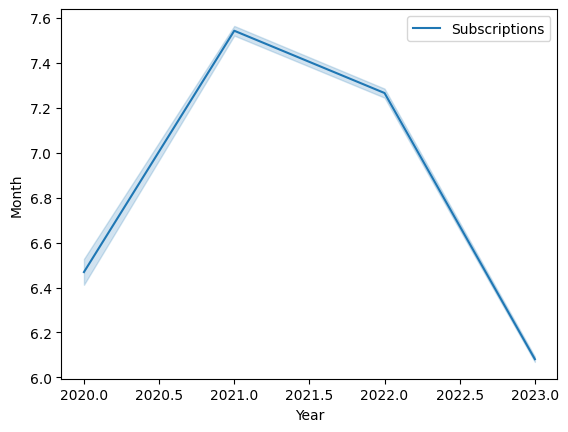

In [101]:
# sns.lineplot(data=df_sb, x="Subs_Year",y="Subs_Month",label="Subscriptions")
# # sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
# plt.xlabel('Year')
# plt.ylabel('Month')
# plt.legend()
# plt.show()

## Ga guna

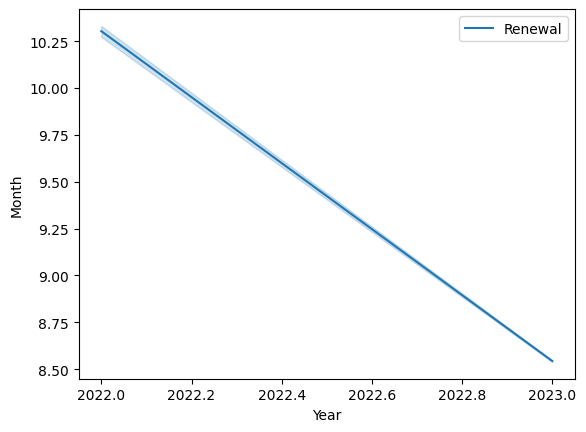

In [102]:
# sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
# plt.xlabel('Year')
# plt.ylabel('Month')
# plt.legend()
# plt.show()

## Ga guna

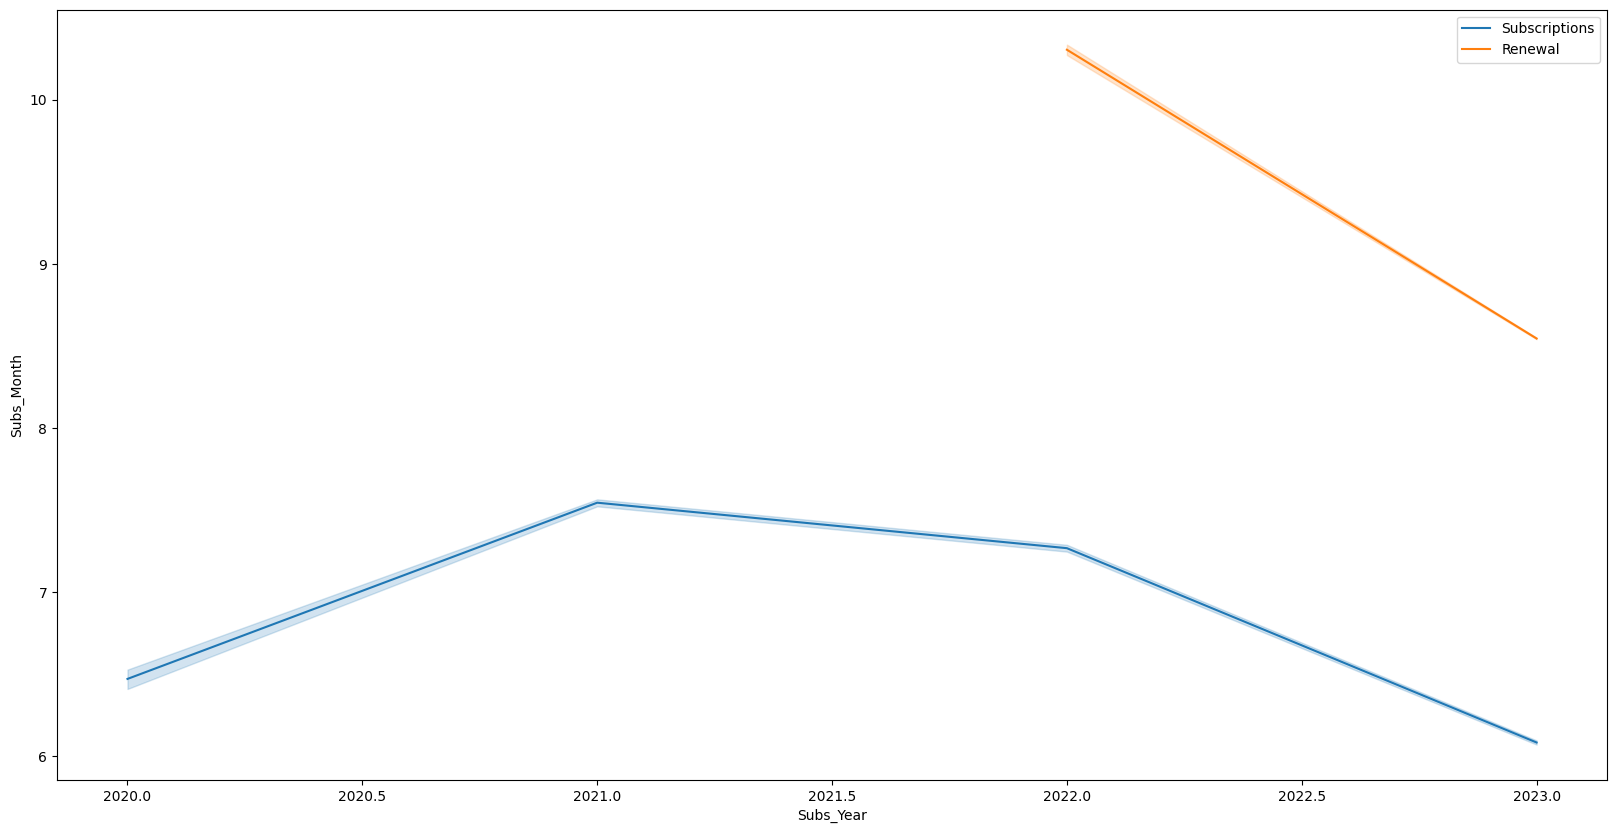

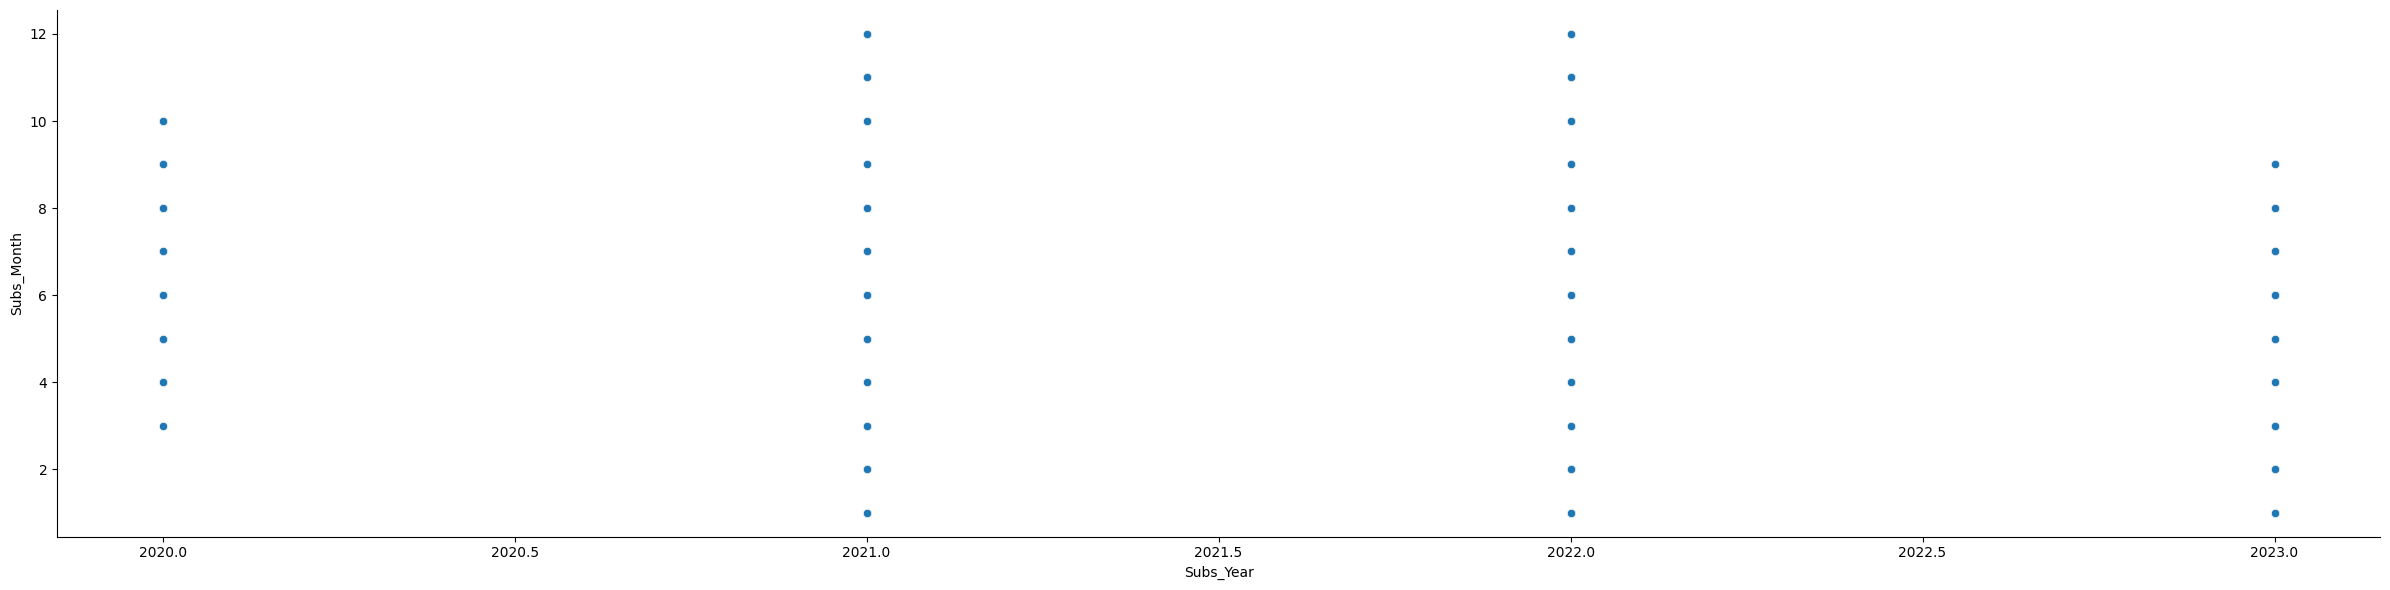

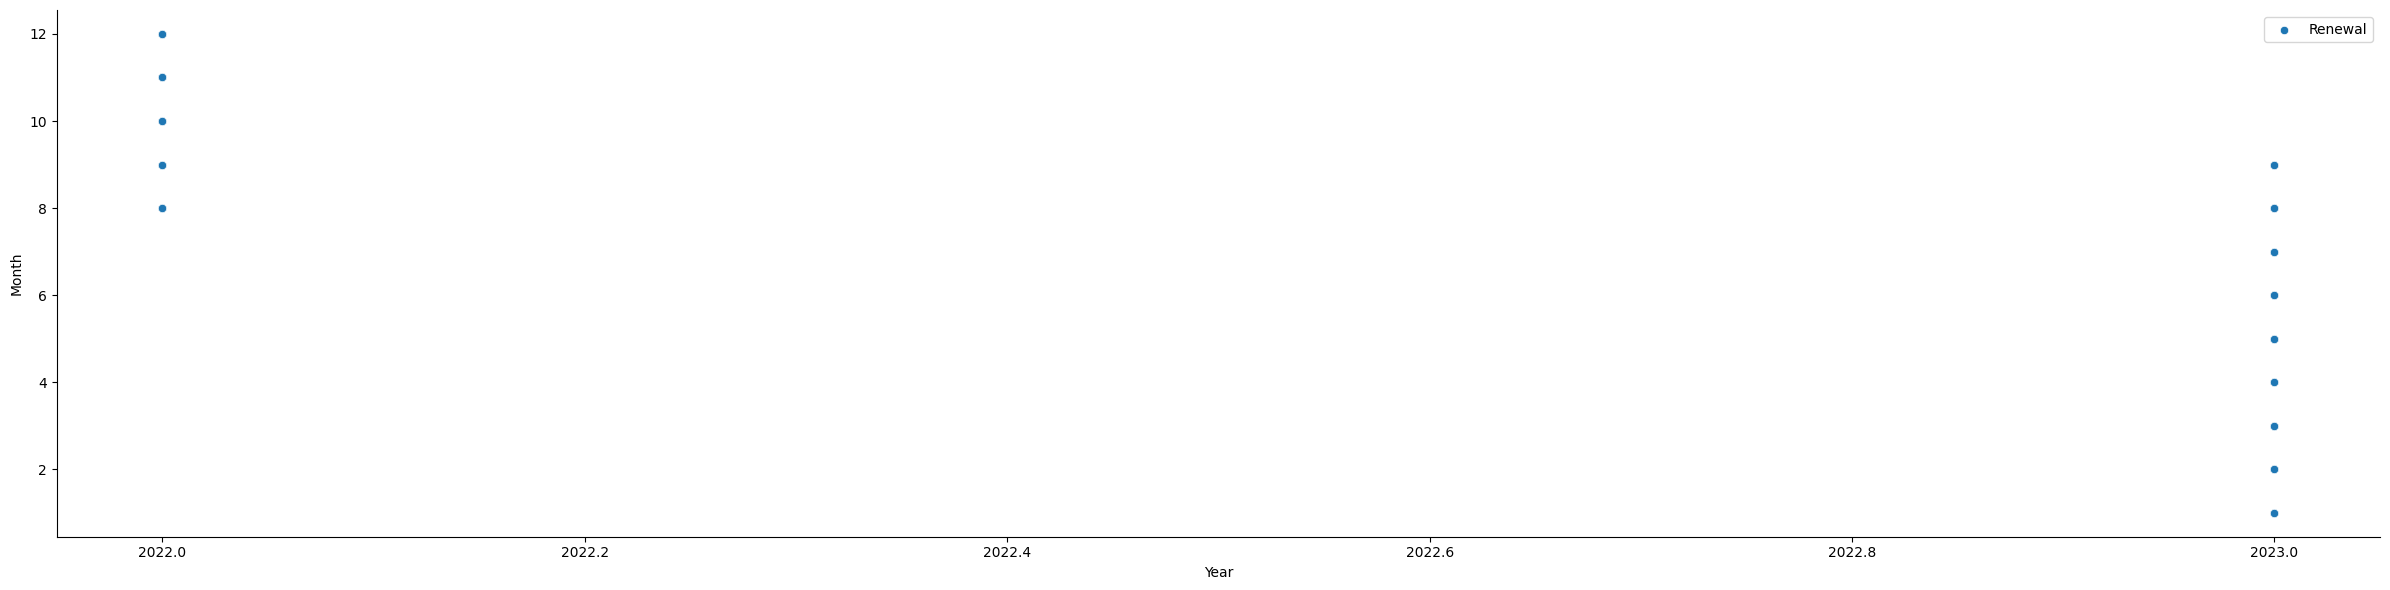

In [103]:
# df_sb["Subs_Year"] = df_sb["subs_date"].dt.year
# df_sb["Subs_Month"] = df_sb["subs_date"].dt.month
# df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
# df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month


# fig = plt.subplots(figsize=(20, 10))
# sns.lineplot(data=df_sb, x="Subs_Year",y="Subs_Month",label="Subscriptions")
# sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
# sns.relplot(data=df_sb, x="Subs_Year",y="Subs_Month",label="Subscriptions", height=6, aspect=4)
# sns.relplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal",height=6, aspect=4)
# plt.xlabel('Year')
# plt.ylabel('Month')
# plt.legend()
# plt.show()

# Ga guna

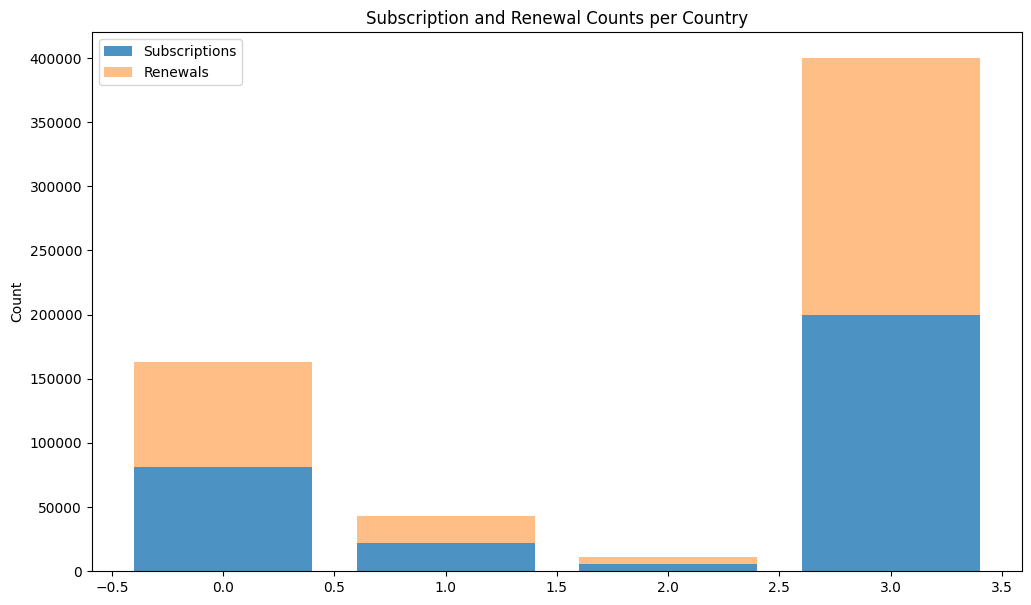

In [104]:
subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
renewals_count = df_sb.groupby('country').size().reset_index(name='Renewal_Count')
subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer').fillna(0)
plt.figure(figsize=(12, 7))
countries = subs_renewals_per_country['country']
y_pos = range(len(countries))
subscription_counts = subs_renewals_per_country['Subscription_Count']
renewal_counts = subs_renewals_per_country['Renewal_Count']

plt.bar(y_pos, subscription_counts, align='center', alpha=0.8, label='Subscriptions')
plt.bar(y_pos, renewal_counts, align='center', alpha=0.5, label='Renewals', bottom=subscription_counts)

# plt.xticks(y_pos, countries)
plt.ylabel('Count')
plt.title('Subscription and Renewal Counts per Country')
plt.legend()

plt.show()

##Per country tapi dalam angka????? Fix this to country!

In [105]:
# df_sb['subs_date'].max()

Timestamp('2023-09-14 00:00:00')

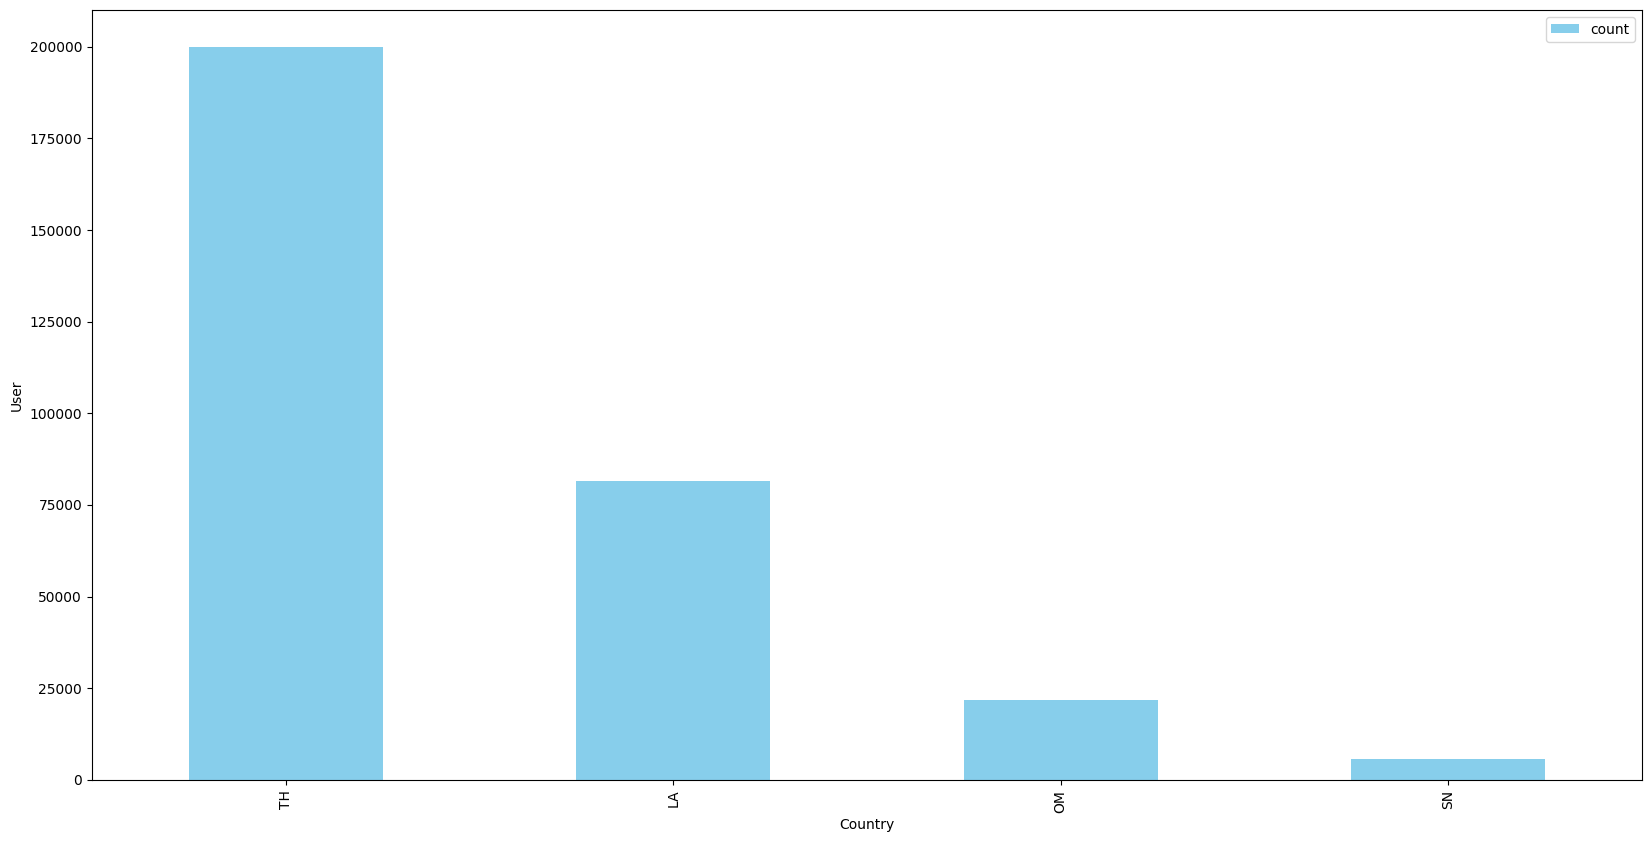

In [106]:
countries = df_sb['country'].value_counts()
topCountries = countries.head(20)
fig = plt.subplots(figsize=(20, 10))

topCountries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('User')
plt.legend()
plt.show()

##Keep this

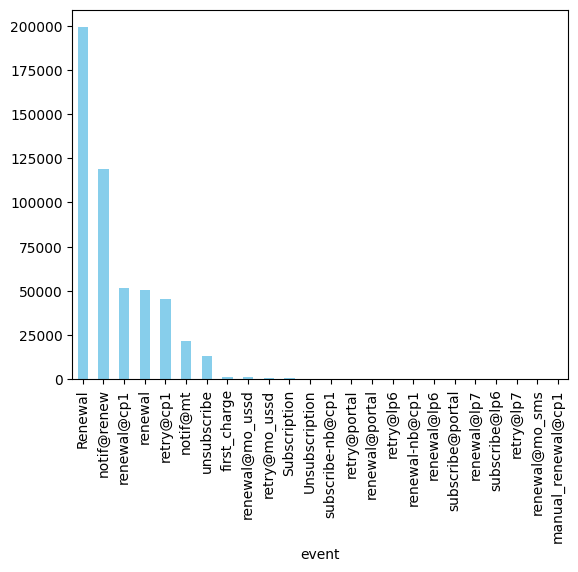

In [107]:
event_cnt = df_tr['event'].value_counts()
event_cnt.plot(kind='bar',color='skyblue')
plt.xticks(rotation=90)
plt.show()

## Renewal, Retry, Notif, Unsubscribe, First_charge, 


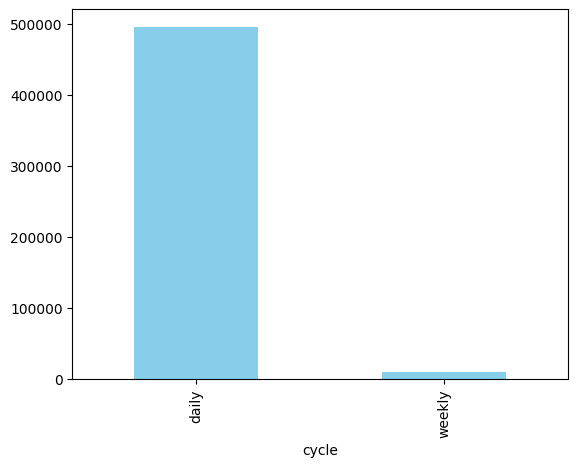

In [108]:
cycle_cnt = df_tr['cycle'].value_counts()
cycle_cnt.plot(kind='bar',color='skyblue')
plt.show()

## Keep this

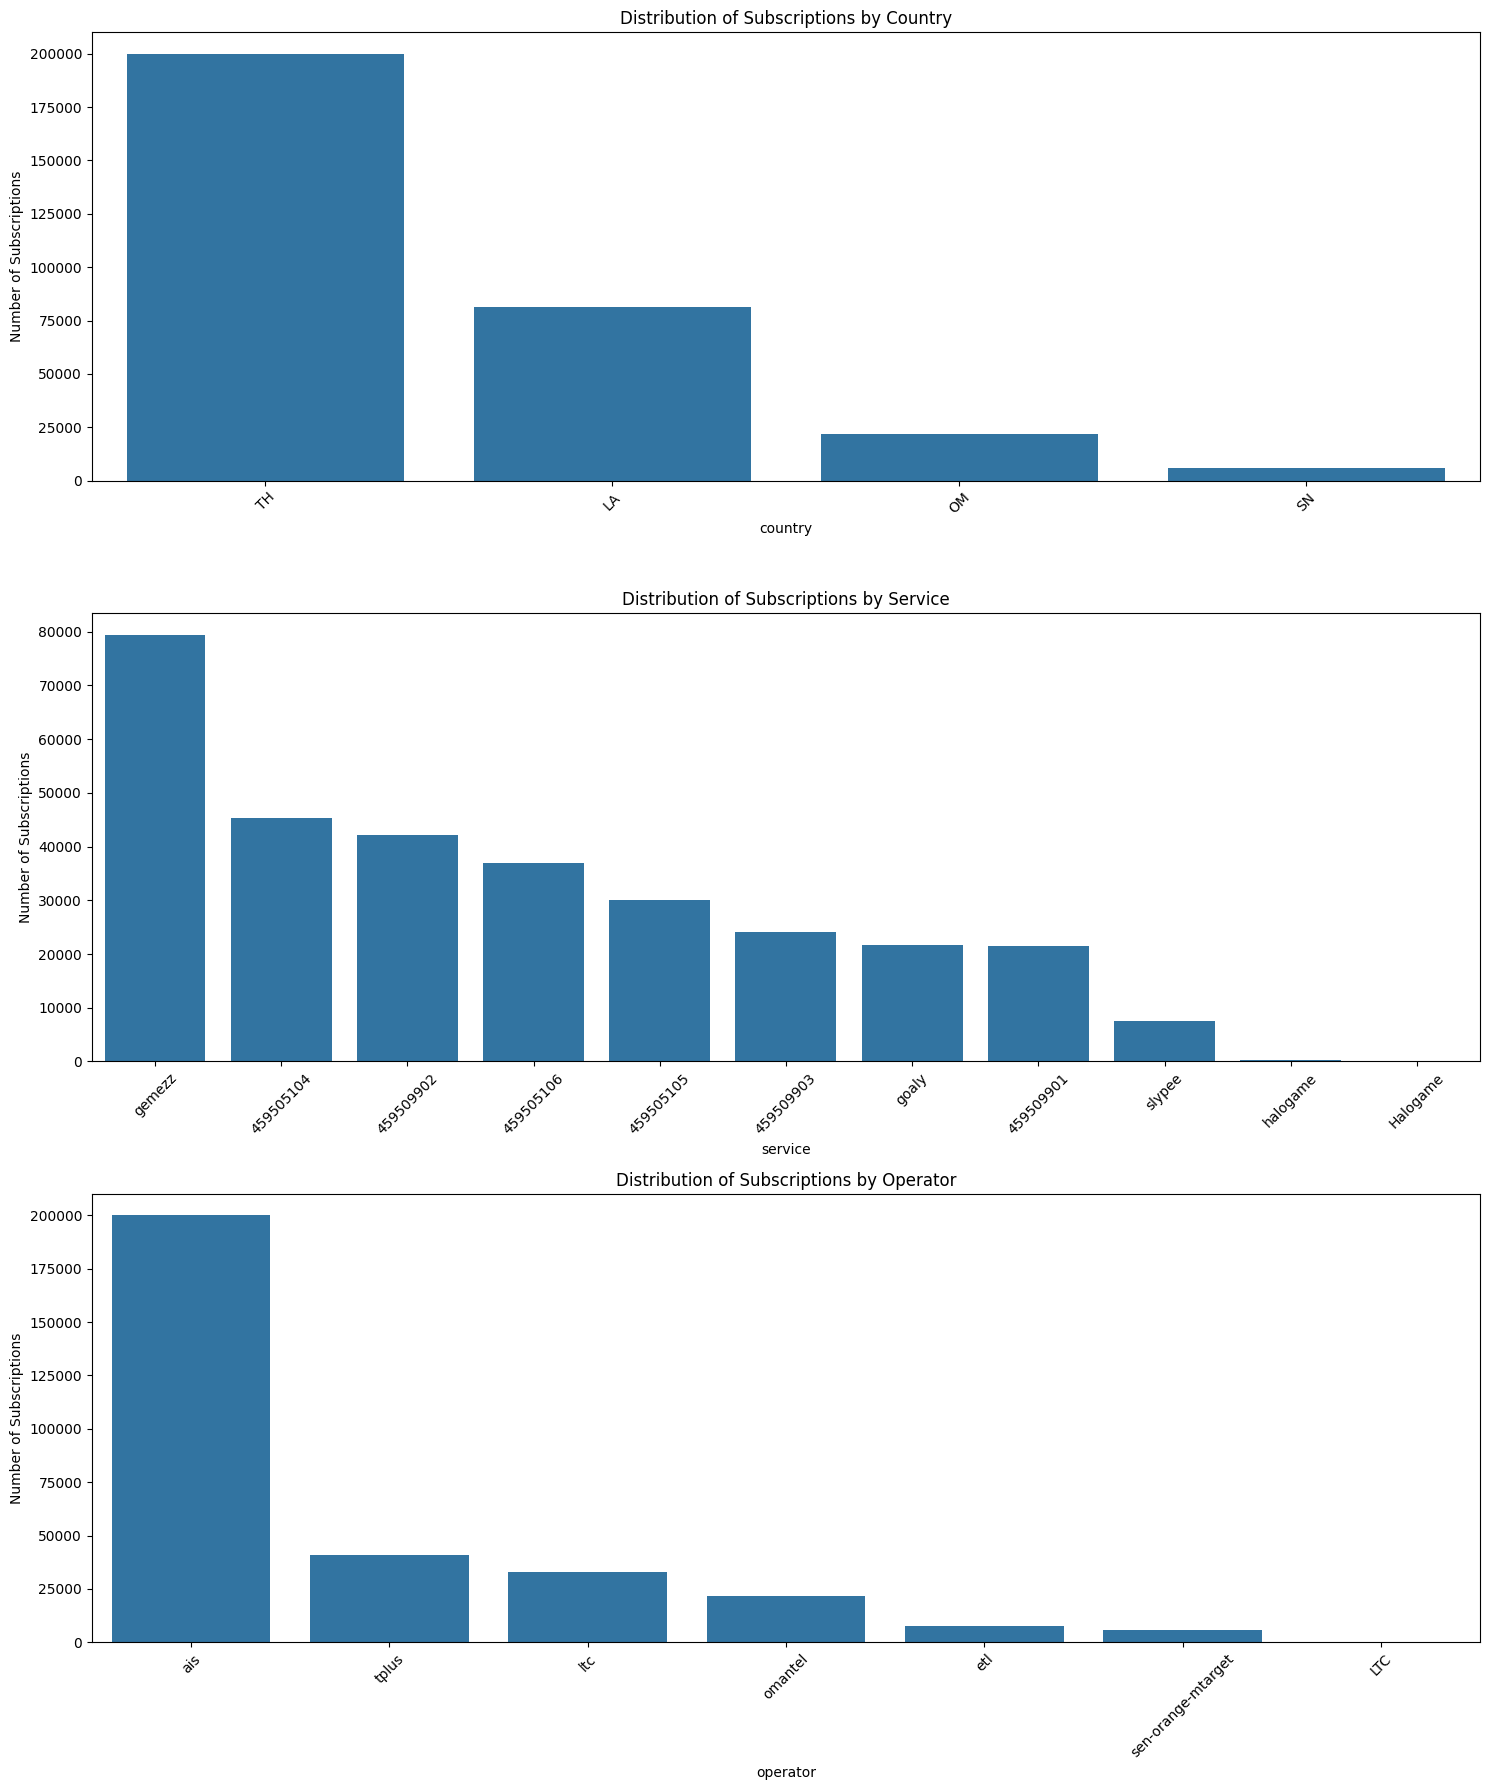

In [109]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

#Country
sns.countplot(data=df_sb, x='country', ax=axes[0], order=df_sb['country'].value_counts().index)
axes[0].set_title('Distribution of Subscriptions by Country')
axes[0].set_ylabel('Number of Subscriptions')
axes[0].tick_params(axis='x', rotation=45)

#Service
sns.countplot(data=df_sb, x='service', ax=axes[1], order=df_sb['service'].value_counts().index)
axes[1].set_title('Distribution of Subscriptions by Service')
axes[1].set_ylabel('Number of Subscriptions')
axes[1].tick_params(axis='x', rotation=45)

#Operator
sns.countplot(data=df_sb, x='operator', ax=axes[2], order=df_sb['operator'].value_counts().index)
axes[2].set_title('Distribution of Subscriptions by Operator')
axes[2].set_ylabel('Number of Subscriptions')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Keep this

##### Merged Data

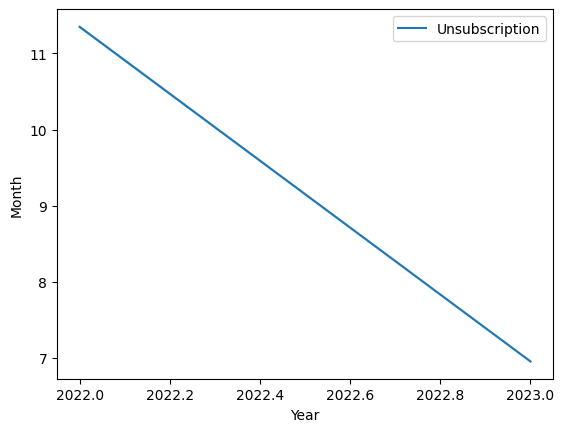

In [110]:
# df_merge["Unsubs_year"] = df_merge["unsubs_date"].dt.year
# df_merge["Unsubs_Month"] = df_merge["unsubs_date"].dt.month
# # df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
# # df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month

# sns.lineplot(data=df_merge, x="Unsubs_year",y="Unsubs_Month",label="Unsubscription")
# # sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
# plt.xlabel('Year')
# plt.ylabel('Month')
# plt.legend()
# plt.show()

## Ga guna

In [111]:
# subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
# renewals_count = df_sb[df_sb['renewal_date'].notna()].groupby('country').size().reset_index(name='Renewal_Count')
# subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer')

# subs_renewals_per_country

### Pre-Training Data (Data Cleaning Part 2)

##### Splitting the data and clean it using regex.

In [112]:
# date_columns = ['created_at_tr', 'charge_date', 'created_at_subs', 'subs_date', 'renewal_date', 'freemium_end_date', 'unsubs_date']
# for col in date_columns:
#     df_merge[col] = pd.to_datetime(df_merge[col], errors='coerce')  # Set errors='coerce' to handle invalid dates

# Convert Currency Columns to Numerical
currency_columns = ['revenue_tr', 'revenue_subs', 'service_price']
for col in currency_columns:
    df_merge[col] = df_merge[col].str.replace('[^\d.]', '', regex=True).astype(float)

In [113]:
df_merge['profile_status'] = df_merge['profile_status'].str.upper()

In [114]:
# df_merge = pd.get_dummies(data=df_merge, columns=['cycle_tr','cycle_subs','profile_status'])




In [115]:
# df_merge['cycle_tr'] = df_merge['cycle_tr'].apply(lambda x : 0 if x == 'daily' else 1)
# df_merge['cycle_subs'] = df_merge['cycle_subs'].apply(lambda x : 0 if x == 'daily' else 1)
# df_merge['profile_status'] = df_merge['profile_status'].apply(lambda x : 1 if x == 'ACTIVE' else 0)

##### Manual LabelEncoder (String -> Integer)

In [116]:
df_merge['cycle_tr'] = df_merge['cycle_tr'].apply(lambda x : 0 if x == 'daily' else 1)
df_merge['cycle_subs'] = df_merge['cycle_subs'].apply(lambda x : 0 if x == 'daily' else 1)


In [117]:
df_merge

,id_tr,created_at_tr,country_tr,operator_tr,service_tr,source_tr,msisdn,event,event_date,cycle_tr,revenue_tr,currency_tr,charge_date,created_at_subs,country_subs,operator_subs,service_subs,source_subs,status,cycle_subs,revenue_subs,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency_subs,profile_status,attempt_charging,success_billing,Renew_Year,Renew_Month,Subs_Year,Subs_Month,Unsubs_year,Unsubs_Month
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,0,0.0,BATH,2023-08-08 00:35:39.000,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,ACTIVE,2,0,2023.0,8.0,2023,8,2023,8
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,0,1500000.0,BATH,2023-08-08 00:00:36.000,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,sms,-1,0,0.0,2023-09-01,2023-08-08,2022-10-15 00:00:00.000,2023-09-01,150.0,BATH,ACTIVE,1,0,2023.0,8.0,2023,9,2023,9
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,0,1500000.0,BATH,2023-08-08 00:03:18.000,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,0,150.0,2023-07-29,2023-08-11,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,ACTIVE,5,1,2023.0,8.0,2023,7,2023,8
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,0,0.0,BATH,2023-08-08 01:09:12.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,ACTIVE,4,0,2023.0,8.0,2023,8,2023,8
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,0,0.0,BATH,2023-08-08 01:09:06.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,ACTIVE,4,0,2023.0,8.0,2023,8,2023,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,0,NaN,LAK,2023-09-08 00:28:32.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023.0,9.0,2023,9,2023,9
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,0,NaN,LAK,2023-09-09 00:25:55.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023.0,9.0,2023,9,2023,9
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,0,NaN,LAK,2023-09-10 00:26:13.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023.0,9.0,2023,9,2023,9
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,0,NaN,LAK,2023-09-11 00:26:39.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023.0,9.0,2023,9,2023,9


In [118]:
df_merge = pd.get_dummies(data=df_merge, columns=['cycle_tr','cycle_subs'])


In [119]:
df_merge = df_merge.replace({True: 1, False: 0})

##### LabelEncoder

In [120]:
df_merge['profile_status'] = LabelEncoder().fit_transform(df_merge['profile_status'])

##### Impute, and Set Data Type to Object

In [121]:
imputer = SimpleImputer(strategy='mean')
df_merge['revenue_subs'] = df_merge['revenue_subs'].values.reshape(-1, 1)
imputer.fit(df_merge[['revenue_subs']])  # Note the double brackets here
df_merge['revenue_subs'] = imputer.transform(df_merge[['revenue_subs']]) 

In [122]:
df_merge['unsubs_date'] = df_merge['unsubs_date'].astype(object)
df_merge['subs_date'] = df_merge['unsubs_date'].astype(object)

##### Splitting the data

In [123]:
X = df_merge[["Renew_Month", "cycle_tr_0", "service_price", "status", "Subs_Month", "profile_status", "attempt_charging", "success_billing"]]
y = df_merge['revenue_subs']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)




In [124]:
len(df_merge.index)


401326

##### Imputing the splitted data, to make sure no NaN Values.

In [125]:
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on X_train (training data)
imputer.fit(X_train)

# Apply the same imputer to X_test (test data)
X_test = imputer.transform(X_test)
X_train = imputer.transform(X_train)

In [126]:
y_imputer = SimpleImputer(strategy='mean')  # You can choose other strategies as well
y_train = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Fit and transform on training data
y_test = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()  # Apply the same imputer to test data


### Data Training

#### Data Model / Techniques

##### Decision Tree

Mean Squared Error: 0.0005980165833068537
R-squared (R2) Score: 0.9999999999997309


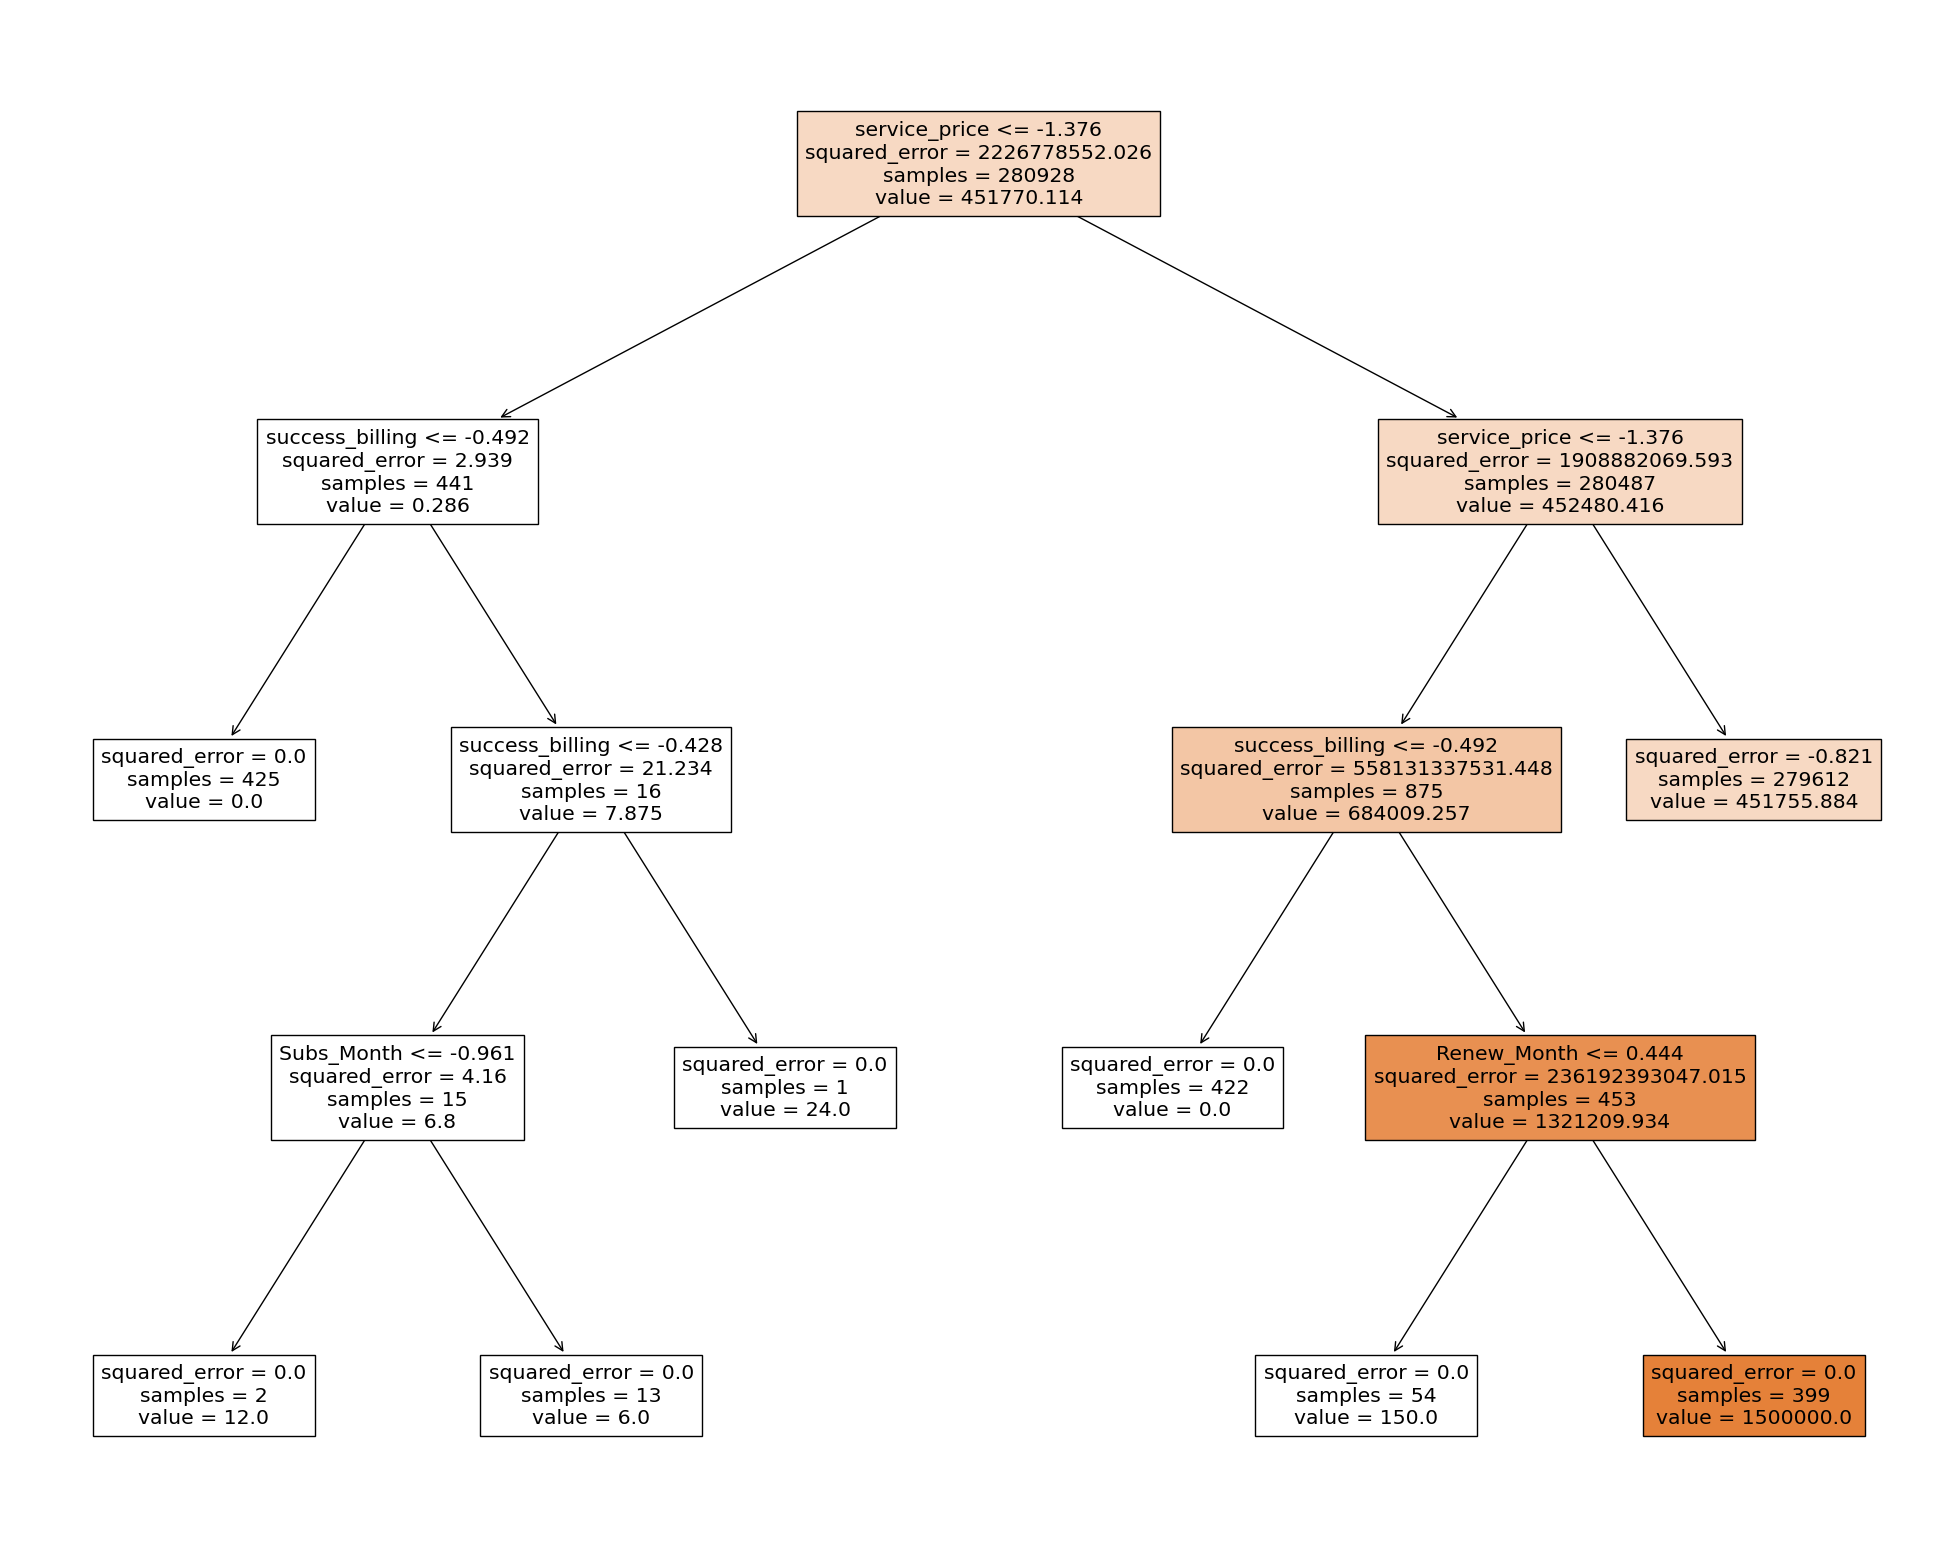

In [127]:
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import render

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)


regresor_tree = DecisionTreeRegressor()
regresor_tree.fit(X_train,y_train)

# export_graphviz(regresor_tree, out_file ='tree.dot', filled=True, rounded=True)  

y_pred = regresor_tree.predict(X_test)
# render('dot', 'png', 'tree.dot')

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared (R2) Score:", r2)

fig = plt.figure()
_ = tree.plot_tree(regresor_tree,feature_names=X.columns, class_names=y, filled=True)

##Save Image (Optional)
# fig.savefig("decistion_tree.png")

##### Random Forest

Mean Squared Error (MSE):  6.105749390258793e-05
R-squared (R2) Score:  0.9999999999999726


[Text(0.5, 0.9, 'service_price <= -1.376\nsquared_error = 2264712388.948\nsamples = 177581\nvalue = 451822.418'),
 Text(0.2, 0.7, 'success_billing <= -0.492\nsquared_error = 2.702\nsamples = 266\nvalue = 0.26'),
 Text(0.1, 0.5, 'squared_error = 0.0\nsamples = 256\nvalue = 0.0'),
 Text(0.3, 0.5, 'success_billing <= -0.428\nsquared_error = 22.776\nsamples = 10\nvalue = 7.714'),
 Text(0.2, 0.3, 'Subs_Month <= -0.961\nsquared_error = 2.556\nsamples = 9\nvalue = 6.462'),
 Text(0.1, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 12.0'),
 Text(0.3, 0.1, 'squared_error = 0.0\nsamples = 8\nvalue = 6.0'),
 Text(0.4, 0.3, 'squared_error = 0.0\nsamples = 1\nvalue = 24.0'),
 Text(0.8, 0.7, 'service_price <= -1.376\nsquared_error = 1964877020.98\nsamples = 177315\nvalue = 452492.471'),
 Text(0.7, 0.5, 'success_billing <= -0.492\nsquared_error = 557630173790.075\nsamples = 564\nvalue = 680319.358'),
 Text(0.6, 0.3, 'squared_error = 0.0\nsamples = 264\nvalue = 0.0'),
 Text(0.8, 0.3, 'Renew_Month <= 0

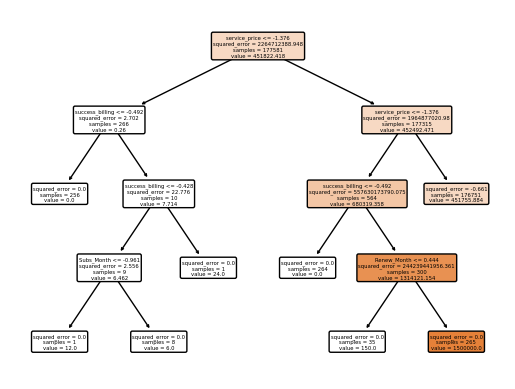

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree


Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2) Score: ", r2)


plot_tree(regressor.estimators_[0], filled=True, rounded=True, feature_names=X.columns)





##### SVR (Support Vector Regression)

In [129]:
# from sklearn.svm import SVR

# # Cut the data to 1/4
# df_merge_25 = df_merge[0:(round(len(df_merge)/4))]
# X = df_merge_25[["Renew_Month", "cycle_tr_0", "service_price", "status", "Subs_Month", "profile_status", "attempt_charging", "success_billing"]]
# y = df_merge_25['revenue_subs']
# X2_train,X2_test,y2_train,y2_test = train_test_split(X, y, test_size=0.2, random_state=42)


# scaler = StandardScaler()
# X2_train = scaler.fit_transform(X_train)
# X2_test = scaler.transform(X_test)

# svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# svr.fit(X_train, y_train)

# y2_pred = svr.predict(X2_test)

# mse = mean_squared_error(y2_test, y2_pred)
# r2 = r2_score(y2_test, y2_pred)

# print("Mean Squared Error: ", mse)
# print("R-squared (R2) Score: ", r2)


##### Linear Regression

mse: 2221607520.5934
r2: 0.00021310013153275076


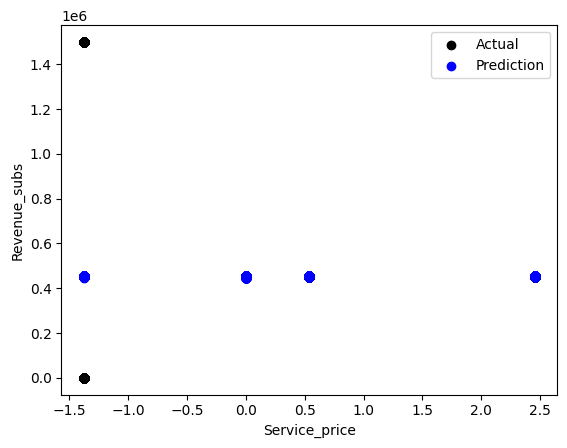

In [130]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse:", mse)
print("r2:", r2)

plt.scatter(X_test[:, 2], y_test, color='black', label='Actual')
plt.scatter(X_test[:, 2], y_pred, color='blue', label='Prediction')
plt.xlabel('Service_price')
plt.ylabel('Revenue_subs')
plt.legend()
plt.show()


##### K-Neighbors Regressor

In [131]:
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)

# plt.scatter(X_test[:, 2], y_test, color='black', label='Actual')
# plt.scatter(X_test[:, 2], y_pred, color='blue', label='Prediction')
# plt.xlabel('Service_price')
# plt.ylabel('Revenue_subs')
# plt.legend()
# plt.show()

# residuals = y_test - y_pred

# plt.scatter(y_test, y_pred, color='blue')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)  # Diagonal line for perfect predictions
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values for KNN Regression')
# plt.show()

# plt.scatter(y_test, residuals, color='green')
# plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Line at y=0 for zero residuals
# plt.xlabel('Actual Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot for KNN Regression')
# plt.show()

KeyboardInterrupt: 